In [27]:
#!/home/akhanal1/Spring2018/pl-env/bin/python3.5
import os
os.chdir('/home/ak/PycharmProjects/ature') 
import sys
import numpy as np
from commons.segmentation import AtureTest
from PIL import Image as IMG
from commons.IMAGE import Image
import cv2
import utils.filter_utils as filutils
import utils.img_utils as imgutils
import copy
# import neuralnet.unet.utils as nut
%load_ext autoreload
%autoreload 2
sep = os.sep

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
i = Image()


In [29]:
i.load_file(data_dir='data/DRIVE/images/', file_name='01_test.tif')
i.working_arr = i.image_arr[:,:,1]

In [30]:
import neuralnet.utils.data_utils as du

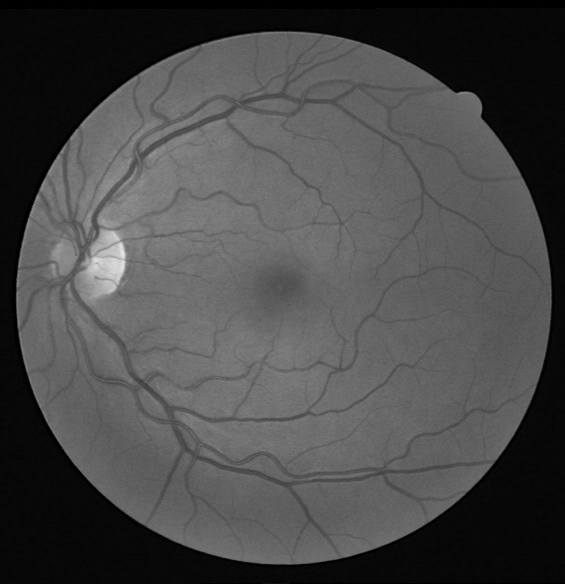

In [38]:
# a = du.get_4_flips(i)
IMG.fromarray(i.working_arr)

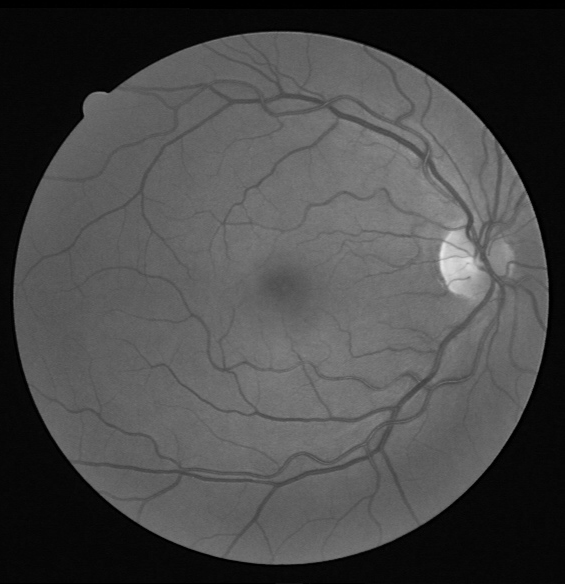

In [42]:
IMG.fromarray(a[3].working_arr)

In [4]:
Dirs = {}

Dirs['data']      = 'data'+sep+'DRIVE'+sep+'testing'

Dirs['images']    = Dirs['data'] +sep+ 'images'
Dirs['mask']      = Dirs['data'] +sep+ 'mask'
Dirs['truth']     = Dirs['data'] +sep+ '1st_manual'
Dirs['segmented'] = 'data'+sep+'DRIVE' +sep+ 'segmented_unet'

for k, folder in Dirs.items():
    os.makedirs(folder, exist_ok=True)

def get_mask_file(file_name): 
    return file_name.split('_')[0] + '_test_mask.gif'
def get_ground_truth_file(file_name): 
    return file_name.split('_')[0] + '_manual1.gif'

input_image = '19_test.tif'

In [5]:
img_obj = SegmentedImage()

img_obj.load_file(data_dir=Dirs['images'], file_name=input_image)
img_obj.working_arr = img_obj.image_arr[:,:,1]
img_obj.apply_clahe()
img_obj.res['orig'] = img_obj.working_arr

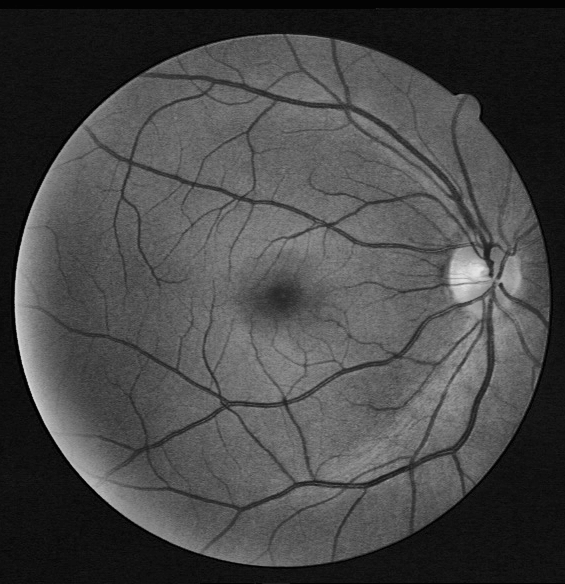

In [6]:
IMG.fromarray(img_obj.working_arr)

In [31]:
x = imgutils.get_chunk_indexes(img_obj.working_arr.shape, (25,25))

In [32]:
ones = []
twos = []
for i, ch in enumerate(x):
    if i%2==0:
        ones.append(img_obj.working_arr[ch[0]:ch[1], ch[2]:ch[3]])
    else:
        ones.append(img_obj.working_arr[ch[0]:ch[1], ch[2]:ch[3]])

In [33]:
xx = list(x)

In [34]:
len(ones)

2256

In [35]:
i1 = nut.merge_patches(scores=np.array(ones), image_size=img_obj.working_arr.shape, training_patch_size=(25, 25))

In [37]:
i1.shape

(584, 565)

In [48]:
x =np.arange(1, 255, 0.2)

In [49]:
x[-1]

254.79999999999995

In [50]:
y = np.linspace(1,255, 510)

In [51]:
y[-1]

255.0